path_to_zip: /root/.keras/datasets/cats_and_dogs_extracted
Constructed PATH: /root/.keras/datasets/cats_and_dogs_extracted/cats_and_dogs_filtered
Caminho do dataset: /root/.keras/datasets/cats_and_dogs_extracted/cats_and_dogs_filtered
Conteúdo do diretório:
total 12
drwxr-xr-x 4 root root 4096 Jul  3 02:12 train
drwxr-xr-x 4 root root 4096 Jul  3 02:12 validation
-rw-r--r-- 1 root root  140 Jul  3 02:15 vectorize.py
Imagens de treino (gatos): 1000
Imagens de treino (cachorros): 1000
Imagens de validação (gatos): 500
Imagens de validação (cachorros): 500
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6004 - loss: 0.6824 - val_accuracy: 0.7450 - val_loss: 0.5255
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.7461 - loss: 0.5060 - val_accuracy: 0.7400 - val_loss: 0.5000
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accu

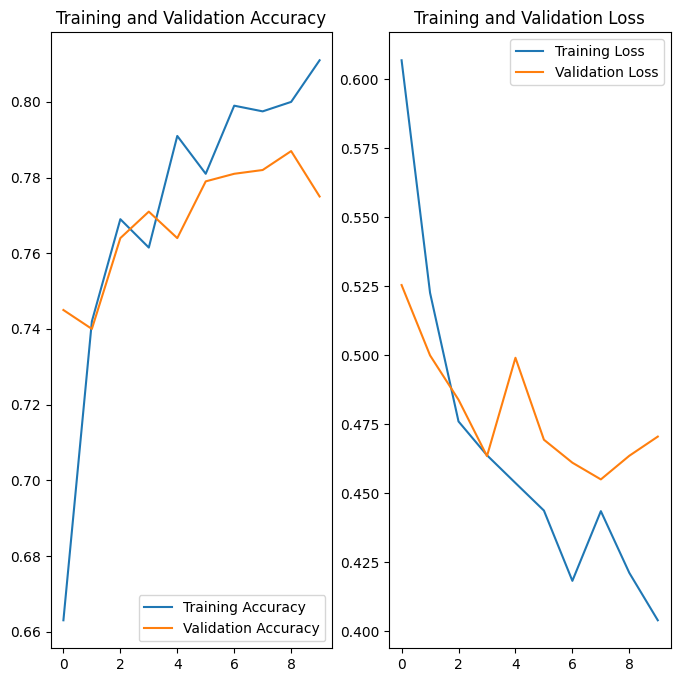

In [5]:
# Importações
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile

# Baixar e descompactar o dataset
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# Definir o caminho do dataset. The extraction creates a directory with the same name as the zip file (without the .zip) in the same directory as the zip file.
PATH = os.path.join(path_to_zip.replace('.zip', ''), 'cats_and_dogs_filtered')

print(f"path_to_zip: {path_to_zip}")
print(f"Constructed PATH: {PATH}")


train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Verificar o conteúdo extraído
print("Caminho do dataset:", PATH)
print("Conteúdo do diretório:")
# Use -l to get more details including permissions and file sizes
!ls -l {PATH}

# Verificar se os diretórios existem
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Diretório de treino não encontrado: {train_dir}")
if not os.path.exists(validation_dir):
    raise FileNotFoundError(f"Diretório de validação não encontrado: {validation_dir}")

# Listar número de imagens para confirmar
print("Imagens de treino (gatos):", len(os.listdir(os.path.join(train_dir, 'cats'))))
print("Imagens de treino (cachorros):", len(os.listdir(os.path.join(train_dir, 'dogs'))))
print("Imagens de validação (gatos):", len(os.listdir(os.path.join(validation_dir, 'cats'))))
print("Imagens de validação (cachorros):", len(os.listdir(os.path.join(validation_dir, 'dogs'))))

# Carregar dataset
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

# Aumentação de dados
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Carregar modelo pré-treinado
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Construir modelo
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(2, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Treinar modelo
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

# Visualizar resultados
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()